In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **Титаник**

В данном исследовании будет производиться классификация пассажиров Титаника, относительно того выжил он\она или нет.

**Описание данных:**
1. `train.csv`:
   * `PassengerId` - порядковый номер пассажира в таблице;
   * `Survived` - таргет. Выжил пассажир или нет (1 - да, 0 - нет);
   * `Pclass` - класс билета (1 - первый класс, 2 - второй, 3 - третий);
   * `Name` - имя пассажира;
   * `Sex` - пол;
   * `Age` - возраст;
   * `SibSp` - кол-во братьев, сестер или супругов на борту Титаника;
   * `Parch` - кол-во родителей, детей на борту Титаника;
   * `Ticket` - номер билета;
   * `Fare` - тариф;
   * `Cabin` - номер каюты;
   * `Embarked` - порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton).
2. `test.csv`:
   * такие же категории данных что и в train.csv, только отсутсвует столбец с таргетом (`Survived`).

**Для оценки силы связи в теории корреляции применяется шкала английского статистика Чеддока:** 
- очень слабая — от 0,1 до 0,3; 
- слабая — от 0,3 до 0,5; 
- средняя — от 0,5 до 0,7; 
- высокая — от 0,7 до 0,9; 
- очень высокая (сильная) — от 0,9 до 1,0.

**План исследования:**
1. Загрузить данные.
2. Предобработать данные (пропуски, аномалии и т.д.).
3. Провести исследовательский анализ данных.
4. Построить модель выживаемости пассажиров.
5. Сделать выводы.

## Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import missingno as msno 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import(
    OneHotEncoder,
    StandardScaler, 
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.exceptions import ConvergenceWarning


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

RANDOM_STATE = 42

### Тренировочная выборка

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


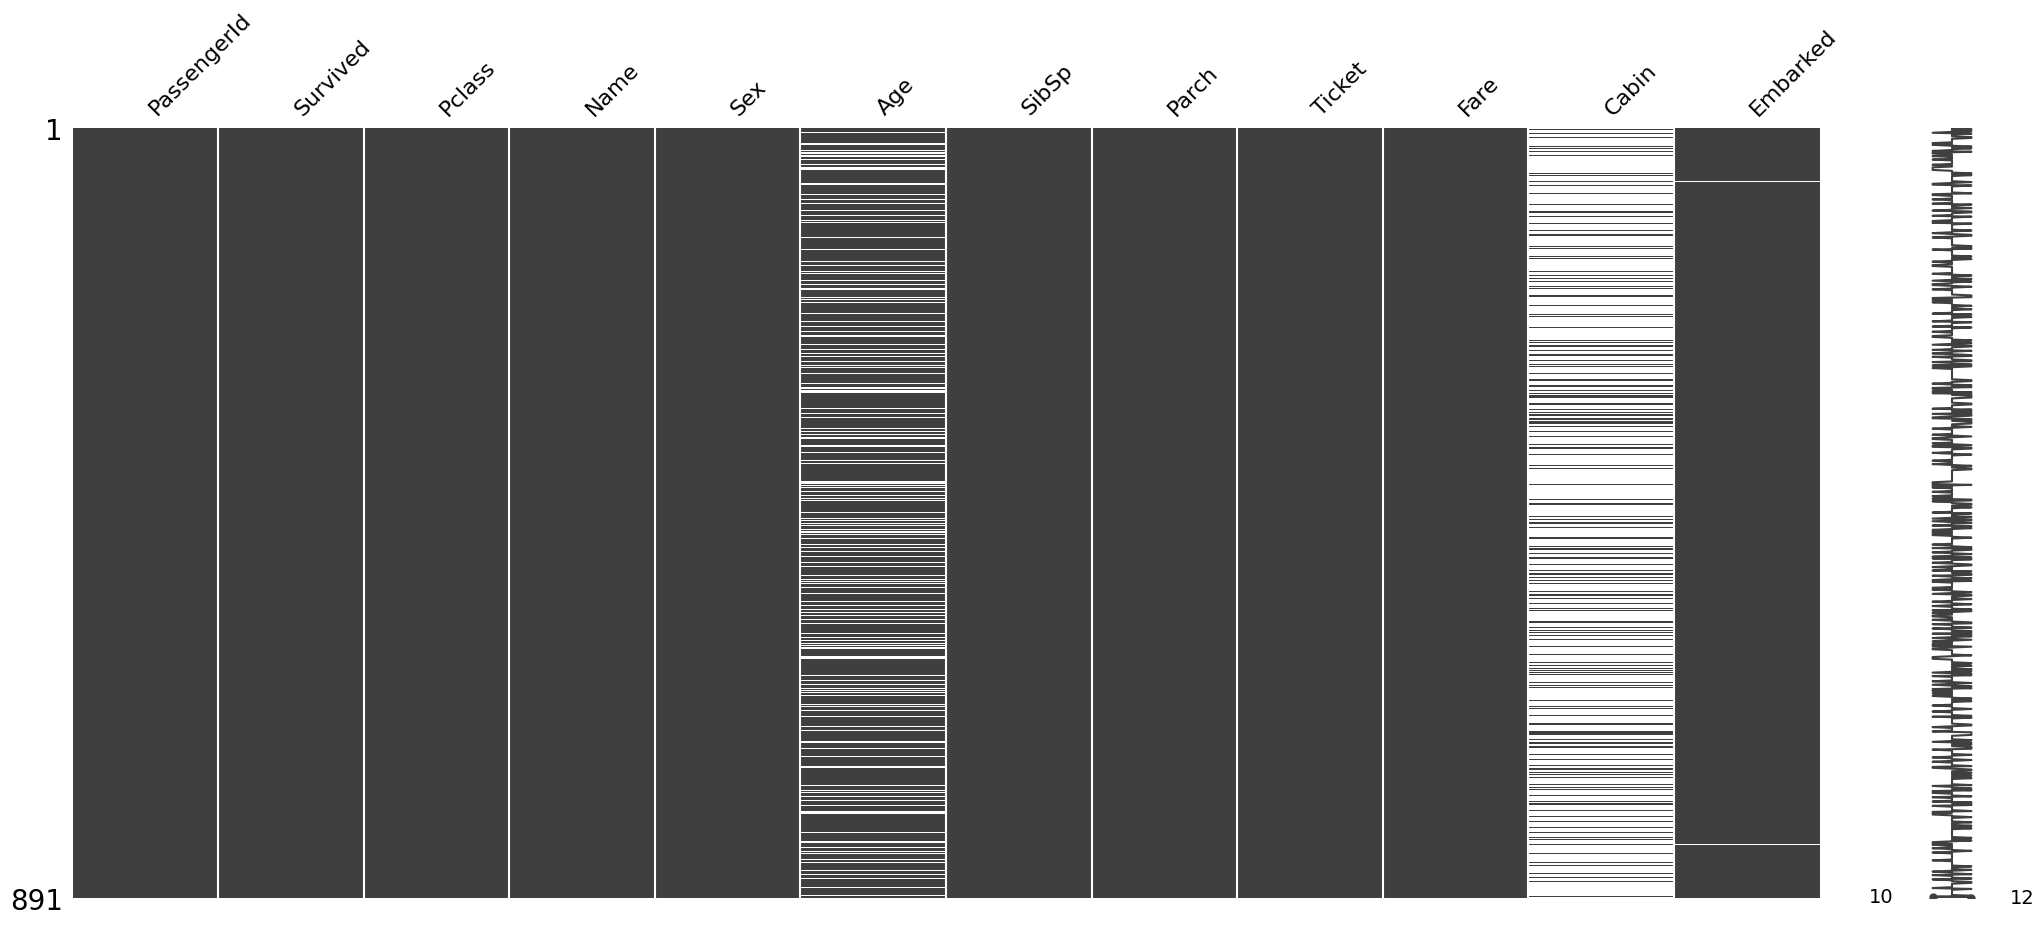

In [7]:
msno.matrix(train)
plt.show()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* в датафрейме `train` содержится 12 столбцов и 891 строка;
* данные соответсвуют описанию;
* есть повторы в столбце `Ticket` и `Cabin`;
* в данных есть пропуски в столбцах `Age`, `Cabin`, `Embarked`;
* типы данных верные.

### Тестовая выборка

In [9]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [10]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [12]:
test.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


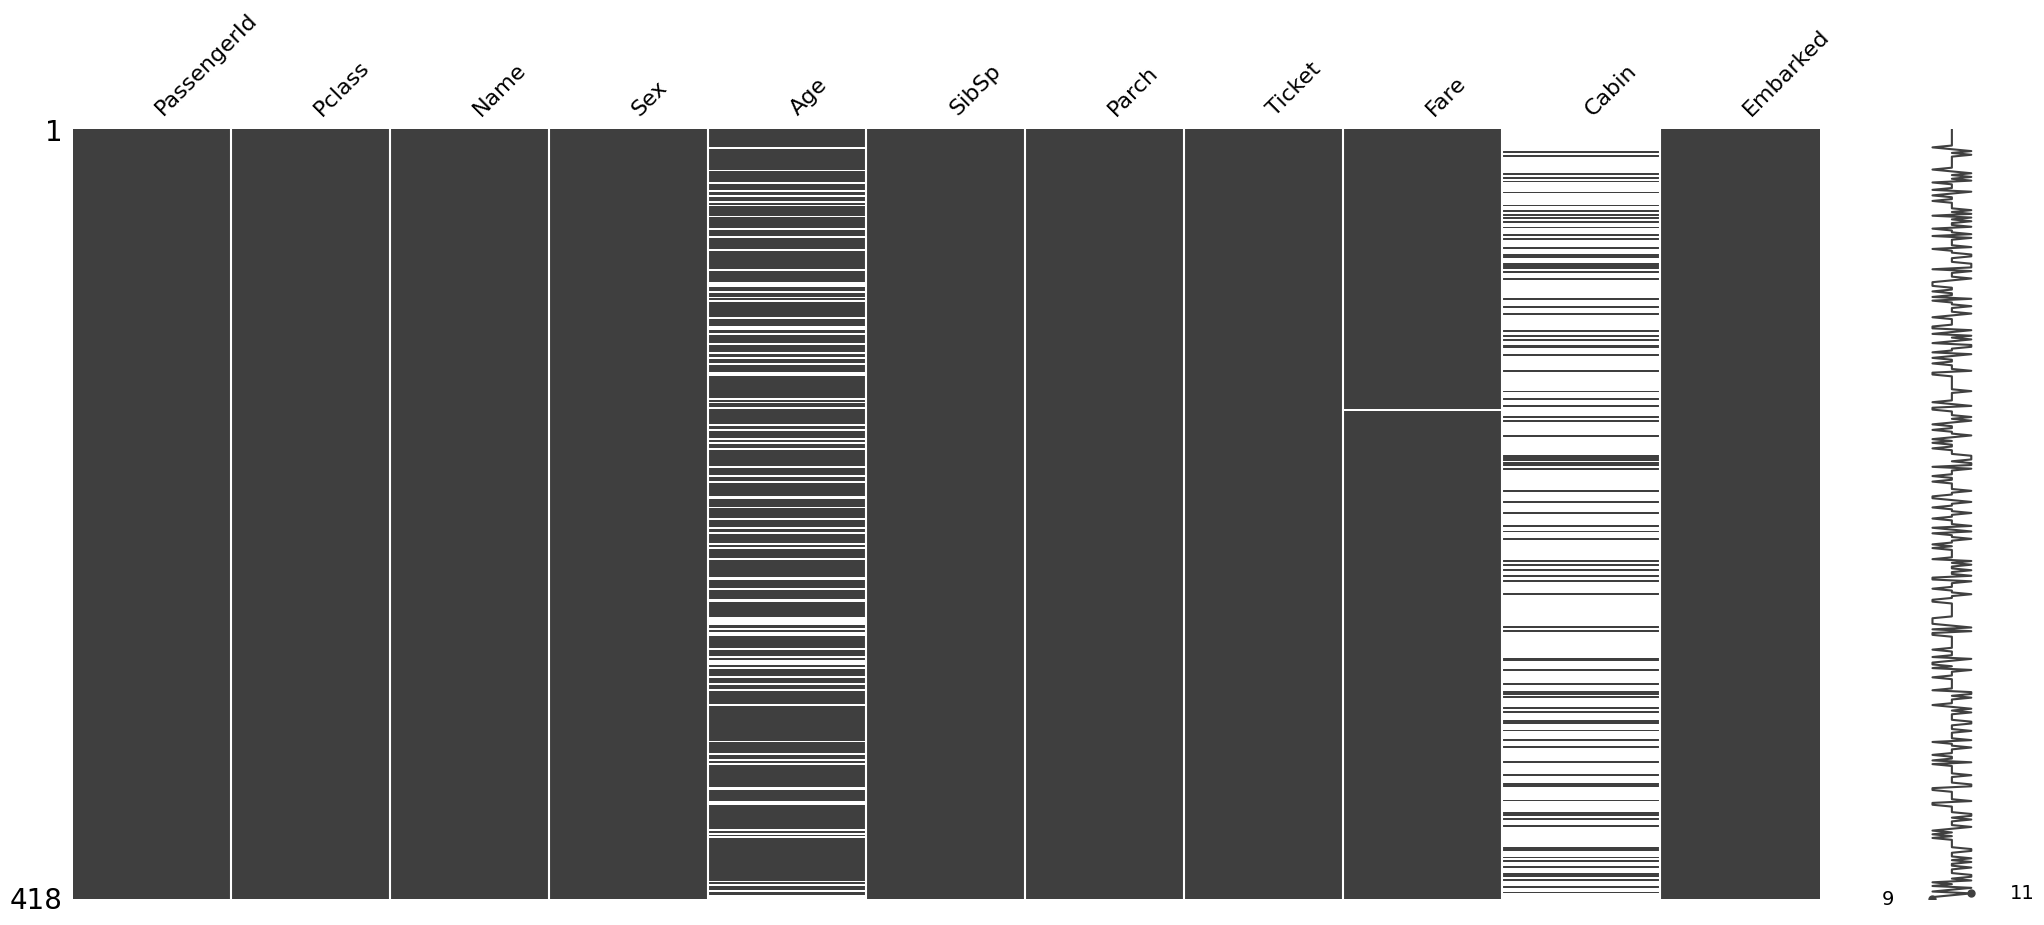

In [13]:
msno.matrix(test)
plt.show()

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


* в датафрейме `test` содержится 11 столбцов и 418 строк;
* данные соответсвуют описанию;
* есть повторы в столбце `Ticket` и `Cabin`;
* очень много пропусков в столбце `Cabin`, так же имеются пропуски в `Age` и `Fare`;
* типы данных верные.

## Предобработка данных

### Тренировочная выборка

In [15]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
train.duplicated().sum()

0

In [17]:
# Заполню пропуски в возрасте средним значением в разбивке по классу билета
for a in train['Pclass'].unique():
    train.loc[(train['Pclass'] == a) & (train['Age'].isna()), 'Age'] = \
    train.loc[(train['Pclass'] == a), 'Age'].mean()

In [18]:
# В этом столбце слишком много пропусков, он неинформативен
train = train.drop('Cabin', axis=1)

In [19]:
# Так как пропусков в этом столбце мало 
# заполню их самым часто встречающимся значением
train['Embarked'] = train['Embarked'].mode()[0]

### Тестовая выборка

In [20]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [21]:
test.duplicated().sum()

0

In [22]:
for a in test['Pclass'].unique():
    test.loc[(test['Pclass'] == a) & (test['Age'].isna()), 'Age'] = \
    test.loc[(test['Pclass'] == a), 'Age'].mean()

In [23]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [24]:
test = test.drop('Cabin', axis=1)

## Исследовательский анализ данных

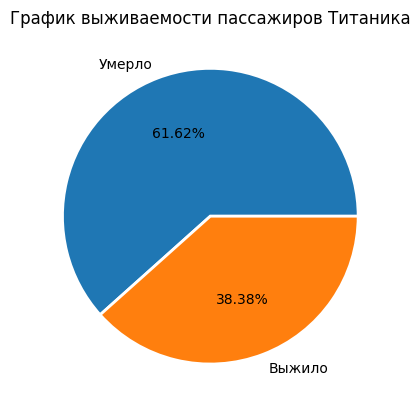

In [25]:
survived_counts = train['Survived'].value_counts()
plt.pie(
    survived_counts,
    labels=['Умерло', 'Выжило'],
    autopct='%1.2f%%',
    wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}
)

plt.title('График выживаемости пассажиров Титаника')
plt.show()

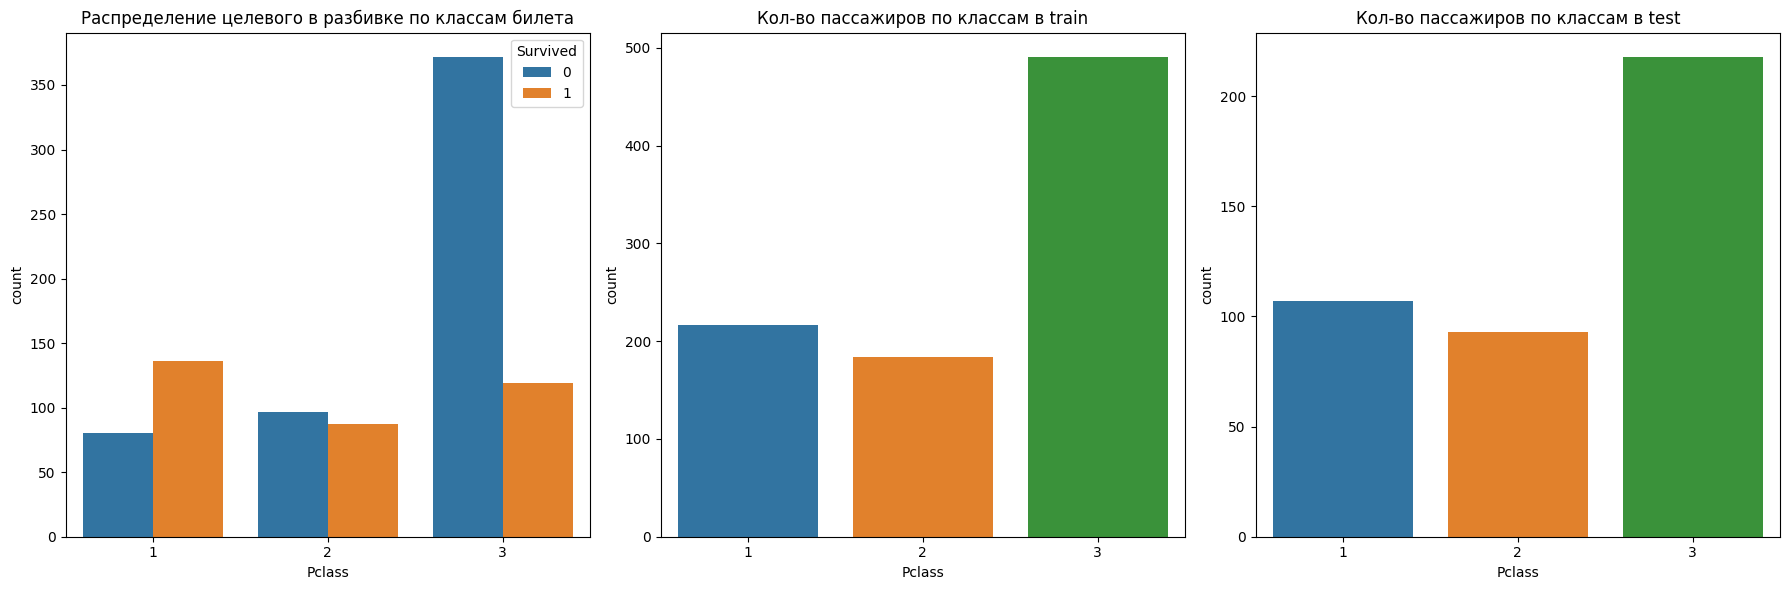

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.countplot(data=train, x='Pclass', hue='Survived', ax=axes[0])
axes[0].set_title('Распределение целевого в разбивке по классам билета')

sns.countplot(x='Pclass', data=train, ax=axes[1])
axes[1].set_title('Кол-во пассажиров по классам в train')

sns.countplot(data=test, x='Pclass', ax=axes[2])
axes[2].set_title('Кол-во пассажиров по классам в test')

plt.tight_layout()
plt.show()

Около 3/4 пассажиров 3 класса погибло, в то время как в 1 и 2 классе это соотношение примерно 50/50. Данные равномерно сбалансированы по выборкам.

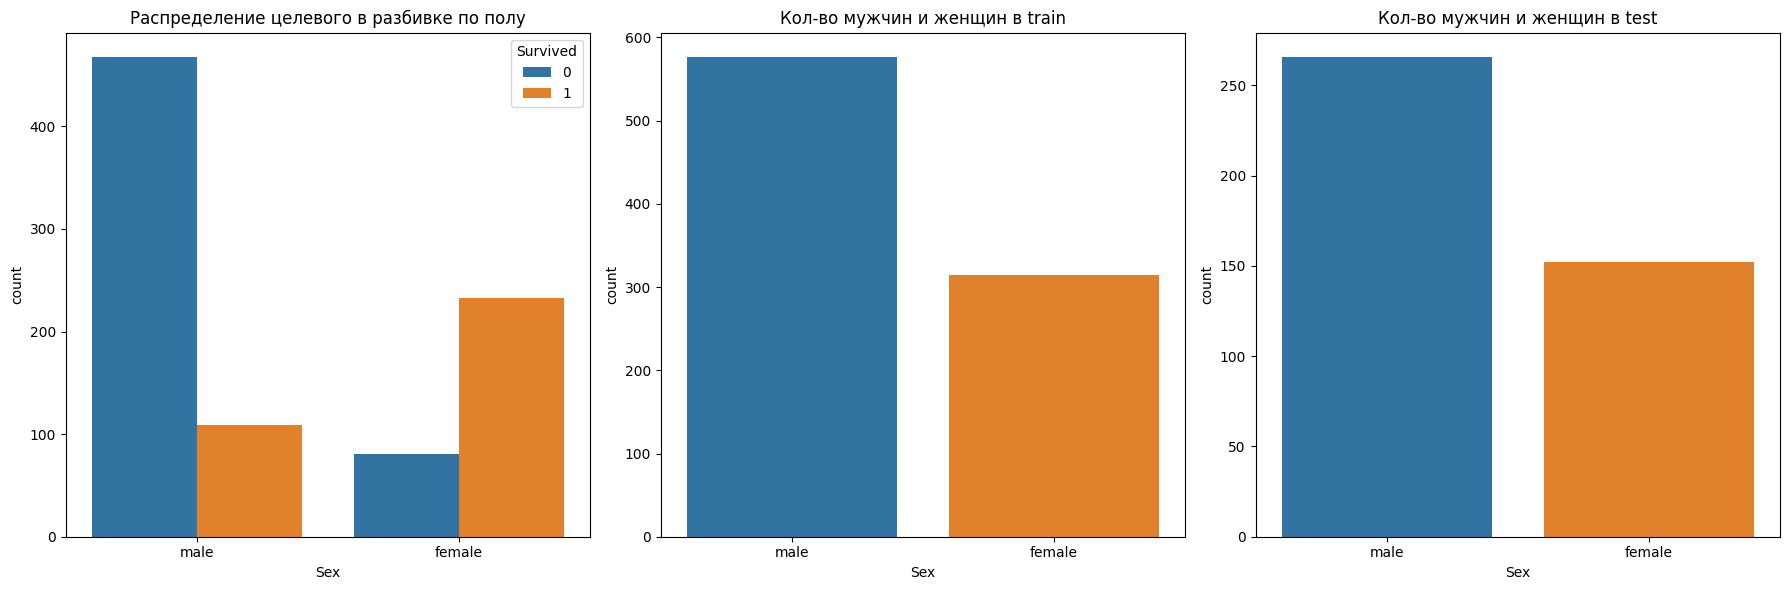

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.countplot(data=train, x='Sex', hue='Survived', ax=axes[0])
axes[0].set_title('Распределение целевого в разбивке по полу')

sns.countplot(x='Sex', data=train, ax=axes[1])
axes[1].set_title('Кол-во мужчин и женщин в train')

sns.countplot(data=test, x='Sex', ax=axes[2])
axes[2].set_title('Кол-во мужчин и женщин в test')

plt.tight_layout()
plt.show()

Большая часть мужчин погибла, в то время как 2/3 женщин выжило. Данные так же равномерно сбалансированы по выборкам.

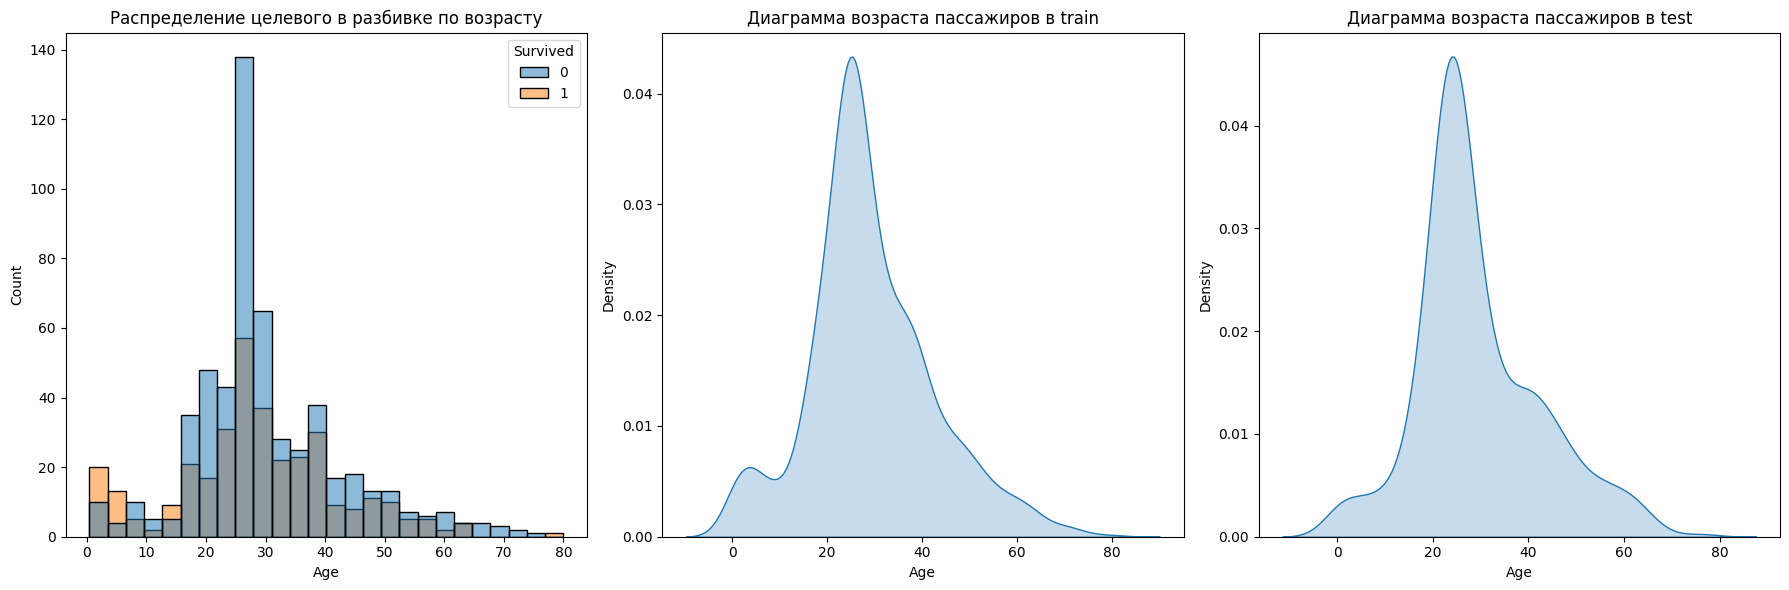

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(data=train, x='Age', hue='Survived', ax=axes[0])
axes[0].set_title('Распределение целевого в разбивке по возрасту')

sns.kdeplot(x='Age', data=train, fill=True, ax=axes[1])
axes[1].set_title('Диаграмма возраста пассажиров в train')

sns.kdeplot(data=test, x='Age', fill=True, ax=axes[2])
axes[2].set_title('Диаграмма возраста пассажиров в test')

plt.tight_layout()
plt.show()

Очень маленькая доля погибших среди детей и людей старшего возраста. Пассажиры одинаково распределены по возрасту между выборками.

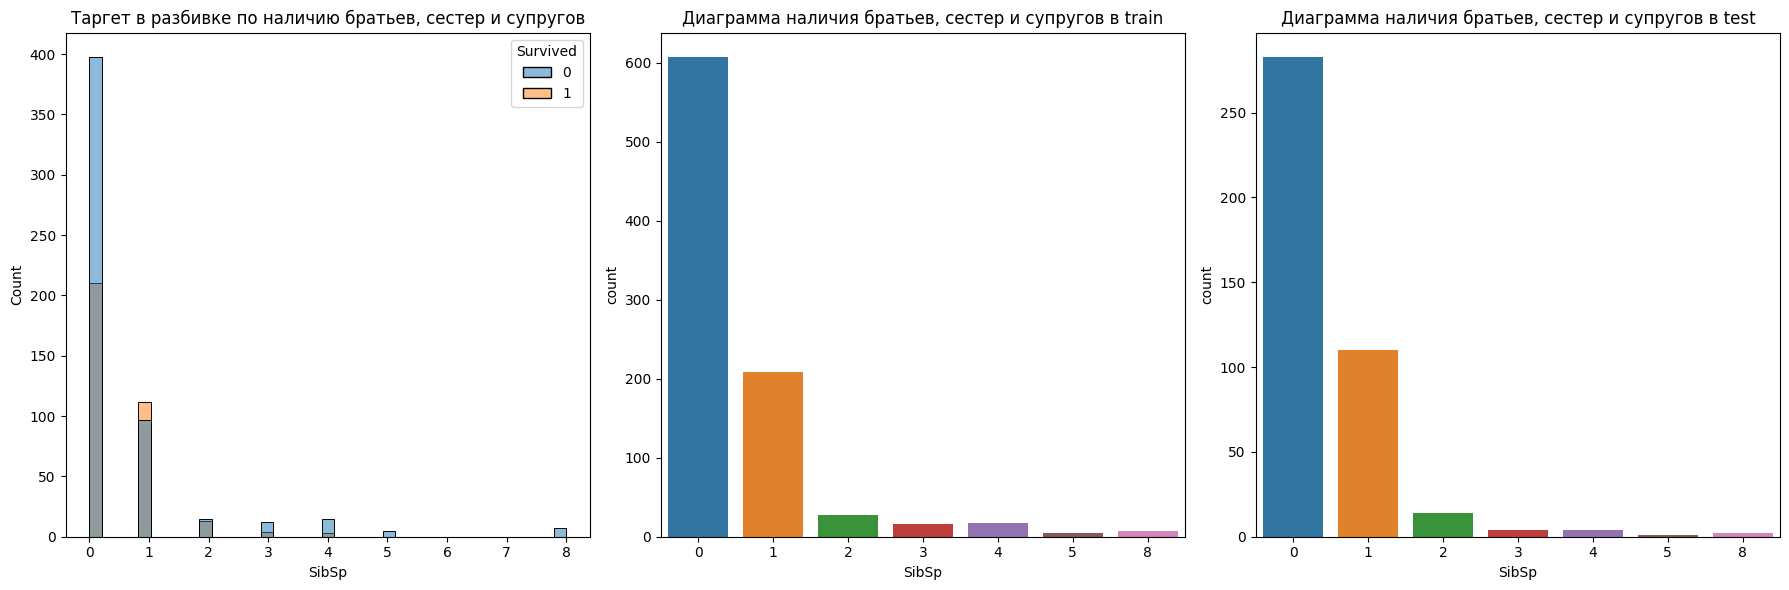

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(data=train, x='SibSp', hue='Survived', ax=axes[0])
axes[0].set_title('Таргет в разбивке по наличию братьев, сестер и супругов')

sns.countplot(x='SibSp', data=train, ax=axes[1])
axes[1].set_title('Диаграмма наличия братьев, сестер и супругов в train')

sns.countplot(data=test, x='SibSp', ax=axes[2])
axes[2].set_title('Диаграмма наличия братьев, сестер и супругов в test')

plt.tight_layout()
plt.show()

Большие семьи выживали хуже. Распределние признака между выборками равномерное.

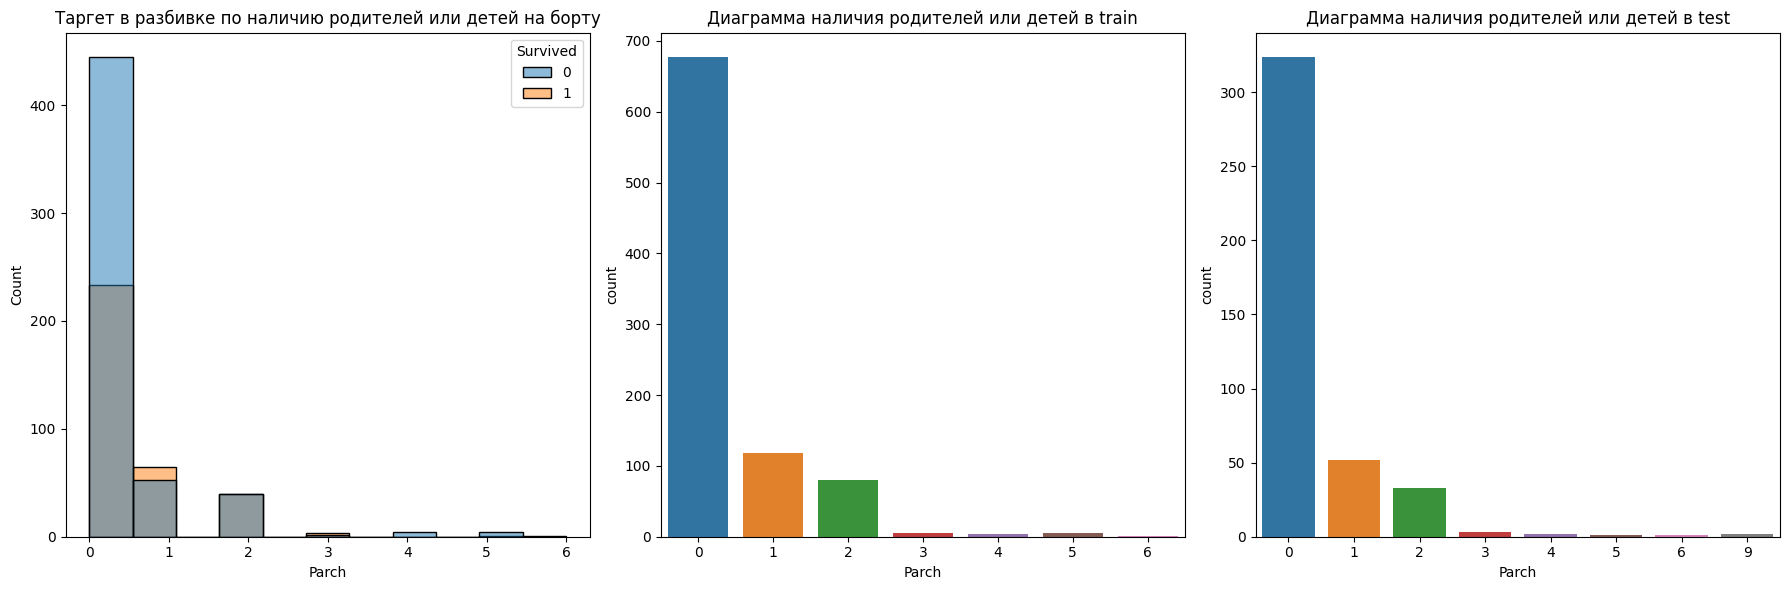

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(data=train, x='Parch', hue='Survived', ax=axes[0])
axes[0].set_title('Таргет в разбивке по наличию родителей или детей на борту')

sns.countplot(x='Parch', data=train, fill=True, ax=axes[1])
axes[1].set_title('Диаграмма наличия родителей или детей в train')

sns.countplot(data=test, x='Parch', fill=True, ax=axes[2])
axes[2].set_title('Диаграмма наличия родителей или детей в test')

plt.tight_layout()
plt.show()

Семьи, в которых было 1 или 2 человека выживали лучше. Так же между выборками есть небольшое расхождение, в train максимальное кол-во родственников 6, а в test 9.

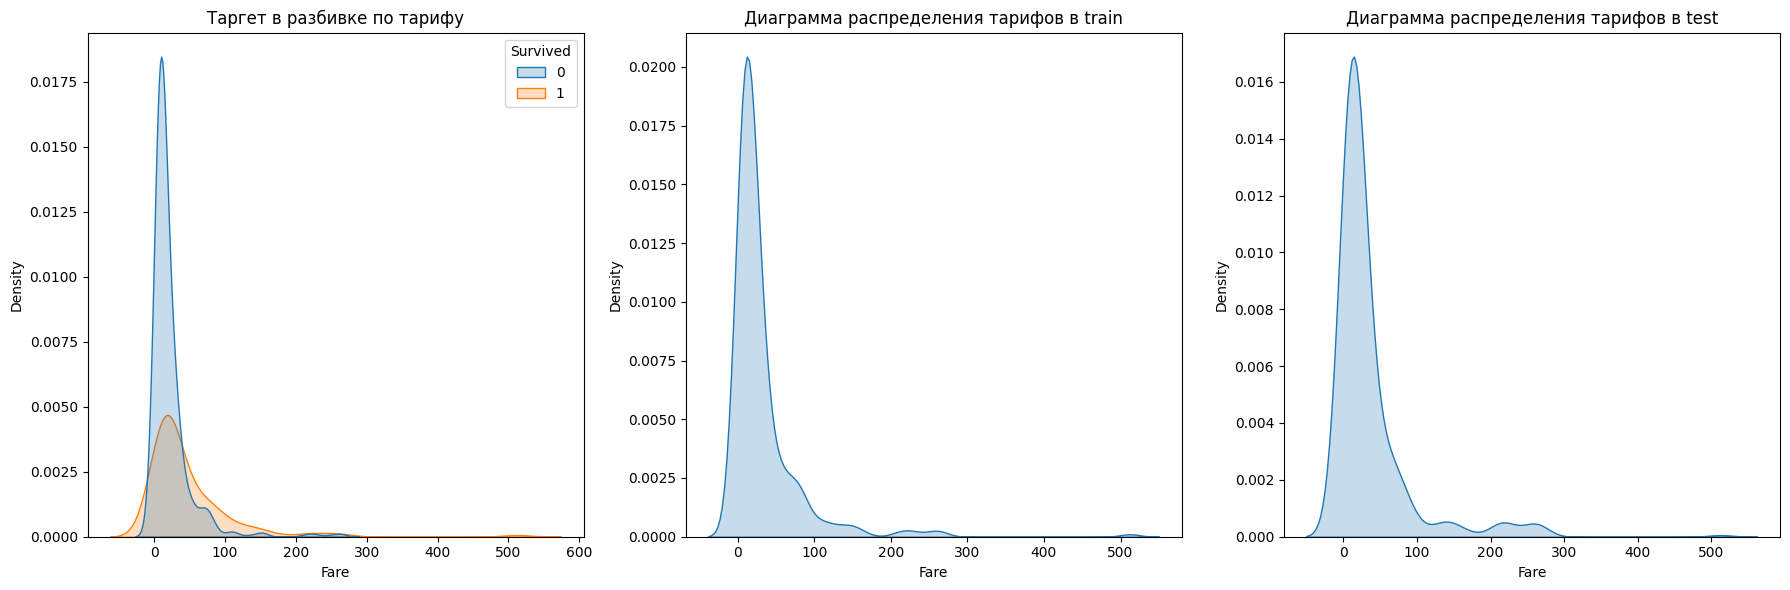

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.kdeplot(data=train, x='Fare', hue='Survived', fill=True, ax=axes[0])
axes[0].set_title('Таргет в разбивке по тарифу')

sns.kdeplot(x='Fare', data=train, fill=True, ax=axes[1])
axes[1].set_title('Диаграмма распределения тарифов в train')

sns.kdeplot(data=test, x='Fare', fill=True, ax=axes[2])
axes[2].set_title('Диаграмма распределения тарифов в test')

plt.tight_layout()
plt.show()

Большая часть пассажиров с самой низкой ценой билета погибла, в то время как выживаемость пассажиров с более высокой стоимостью билета 50% и выше. Распределение данных между выборками равномерное.

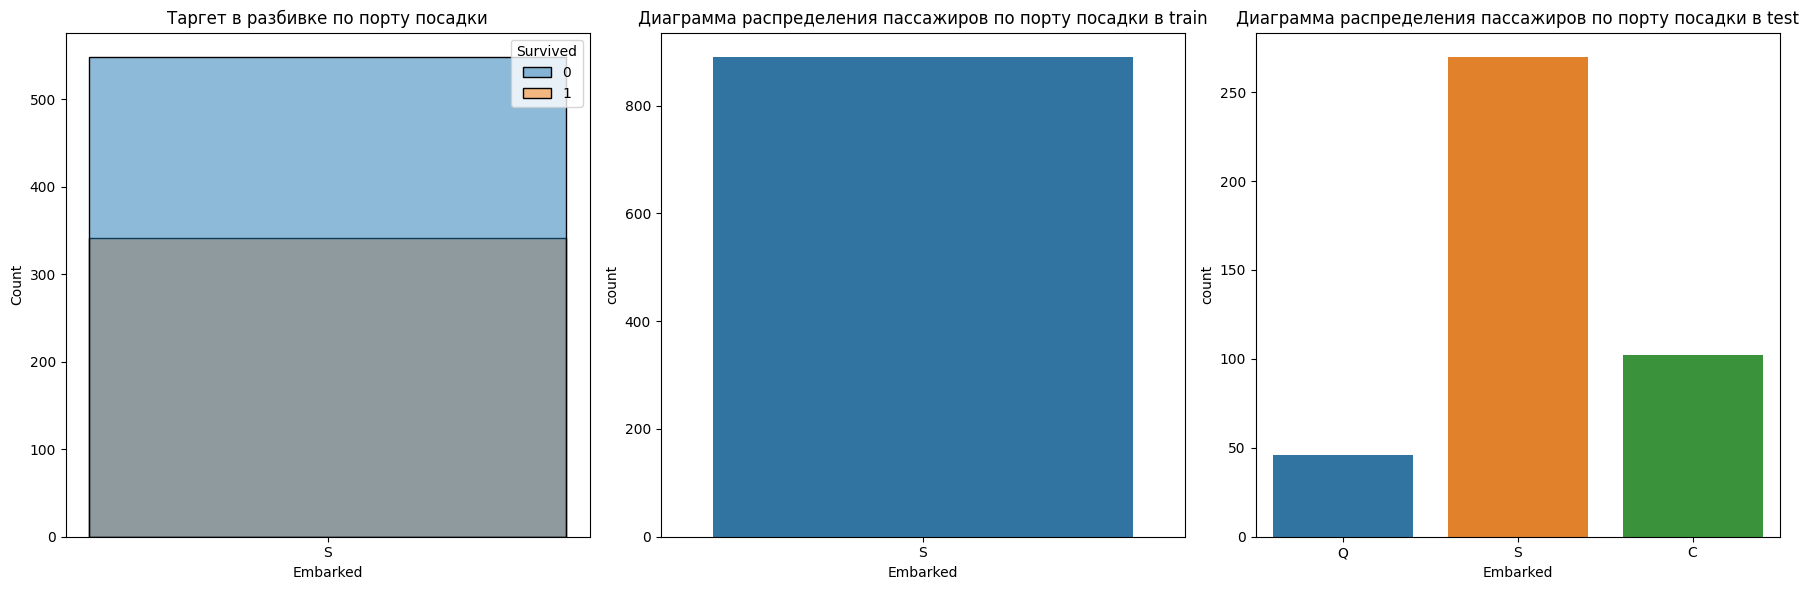

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(data=train, x='Embarked', hue='Survived', fill=True, ax=axes[0])
axes[0].set_title('Таргет в разбивке по порту посадки')

sns.countplot(x='Embarked', data=train, fill=True, ax=axes[1])
axes[1].set_title('Диаграмма распределения пассажиров по порту посадки в train')

sns.countplot(data=test, x='Embarked', fill=True, ax=axes[2])
axes[2].set_title('Диаграмма распределения пассажиров по порту посадки в test')

plt.tight_layout()
plt.show()

В train представлен только один порт посадки S = Southampton, а в test все три порта. Этот признак неинформативен, его следует удалить.

In [33]:
train_data = train.copy()
train_data = train_data.drop('Embarked', axis=1)

In [34]:
# Создам новый признак с общим количеством родственников на борту
train_data['Relatives'] = train_data['Parch'] + train_data['SibSp']

In [35]:
# Функция для создания нового признака кол-ва родственников по группам
def group_relatives(relatives):
    if relatives == 0:
        return 'zero ralatives' 
    if relatives == 1:
        return 'one relative'
    return'two and more'

In [36]:
train_data['GrRel'] = train_data['Relatives'].apply(group_relatives)

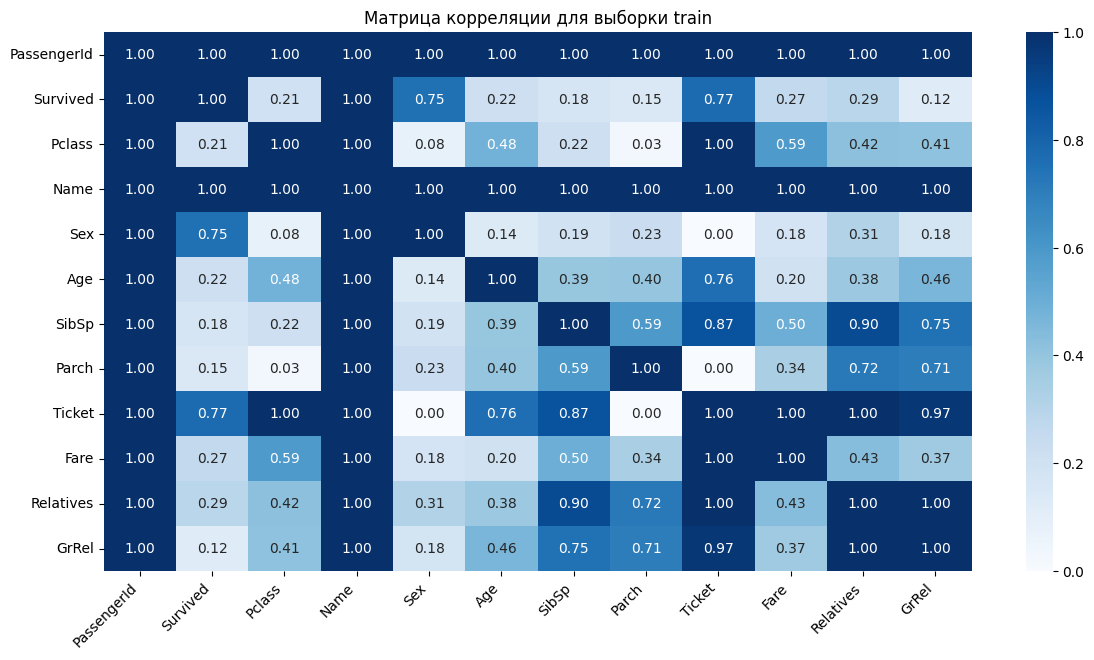

In [37]:
corr_train = train_data.phik_matrix(interval_cols=['Age', 'Fare'])
plt.figure(figsize=(14,7))
heatmap = sns.heatmap(corr_train, annot=True, cmap='Blues', fmt='.2f')
plt.title('Матрица корреляции для выборки train')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.show()

Мультиколлинеарность наблюдается между признаками: `'PassengerId'`, `'Name'` и `'Ticket'`. Их следует удалить, чтобы не исказить выводы линейной модели.

Так же создание нового признака `'GrRel'` с разделением количества родственников на группы не принесло ожидаемых результатов, т.к. его корреляция с таргетом составила всего 0.12, новый признак следует удалить из за неинформативности, так же как `'Parch'` и `'SibSp'`.

Зато признак с суммарным количеством родственников `'Relatives'` оказался полезным, т.к. имеет корреляцию с целевым 0.29, его следует оставить.

In [38]:
train_data = train_data.drop(['PassengerId', 'Name', 'Ticket', 'GrRel', 'Parch', 'SibSp'], axis=1)

In [39]:
test_data = test.copy()
test_data['Relatives'] = test_data['Parch'] + test_data['SibSp']

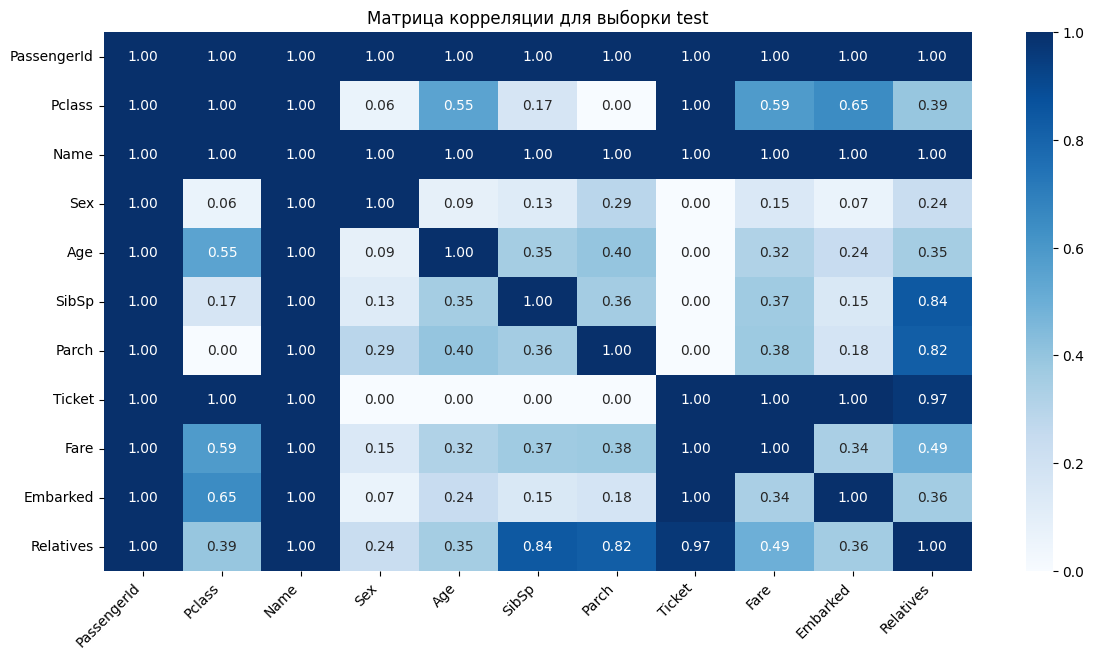

In [40]:
corr_test = test_data.phik_matrix(interval_cols=['Age', 'Fare'])
plt.figure(figsize=(14,7))
heatmap = sns.heatmap(corr_test, annot=True, cmap='Blues', fmt='.2f')
plt.title('Матрица корреляции для выборки test')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.show()

Наблюдается мультиколлинерность (коэффициент коллинеарности выше 0,9) между признаками в тестовой выборке: `'PassengerId'`, `'Name'` и `'Ticket'`. Их следует удалить из данных для прогнозирования. 

Так же новый признак `'Relatives'` хорошо себя показал, а его братьев `'SibSp'` и `'Parch'` следует удалить, т.к. они слабо коррелируют с другими признаками.

In [41]:
test_data = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'SibSp', 'Parch'], axis=1)

## Построение моделей

In [42]:
X_train = train_data.drop('Survived', axis=1)
X_test = test_data
y_train = train_data['Survived']

ohe_columns = ['Sex', 'Pclass']
num_columns = ['Age', 'Fare', 'Relatives']

ohe_pipe = Pipeline(
    [(
        'simpleImputer',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )]
)


num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

final_pipeline = Pipeline([
    ('data_preprocessor', data_preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(3, 8),
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__C': [0.5, 1, 2],
        'model__max_iter': [100, 200],
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [SVC(
            random_state=RANDOM_STATE, 
            probability=True)],
        'model__C': [0.1, 1, 10],
        'model__gamma': [0.01, 0.1],
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [10, 20],
        'model__max_depth': [3, 5],
     'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {'model': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'model__iterations': [10, 20],
        'model__learning_rate': [0.05, 0.1],
     'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)],
        'model__n_estimators': [10, 20],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [2, 4],
        'model__num_leaves': [10, 20],
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')],
        'model__n_estimators': [10, 20],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [2, 4],
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
'Лучшая модель и её параметры:', best_model

('Лучшая модель и её параметры:',
 Pipeline(steps=[('data_preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe',
                                                   Pipeline(steps=[('simpleImputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False))]),
                                                   ['Sex', 'Pclass']),
                                                  ('num', StandardScaler(),
                                                   ['Age', 'Fare',
              

In [44]:
f'Метрика лучшей модели на кросс-валидации: {grid_search.best_score_}'

'Метрика лучшей модели на кросс-валидации: 0.8372418555018516'

In [45]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [46]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_pred
})

In [47]:
submission.to_csv('submission.csv', index=False)

## Выводы

### В этом проекте я проделала следующую работу:
1. Загрузила и изучила данные из 2 датафреймов: `train` и `test`.
2. Выполнила предобработку данных: обработала пропущенные значения в столбцах `Age`, `Cabin`, `Embarked`, `Fare`.
3. Провела исследовательский анализ данных, рассмотрела распределение целевого признака в констексте входных.
4. Добавила два новых входных признака: `Relatives` - общее количество родственников на борту и `GrRel` - разбивка количества родственников по группам.
5. Построила матрицу корреляции для всех признаков методом `phik`.
6. С помощью пайплайна с использованием моделей `RandomForestClassifier`, `LogisticRegression`, `KNeighborsClassifier`, `SVC`, `CatBoostClassifier`, `LightGBM`, `XGBClassifier` и подбором гиперпараметров была определена лучшая модель для предсказания выживаемости пассажиров Титаника.
7. Для лучшей модели классификации рассчитана метрика `Accuracy`. 

### На основании проделанной работы можно сделать следующие выводы:
1. Примерное распределение пассажиров Титаника: умерло около 62%, выжило около 38%.
2. Высокий процент умерших приходится на пассажиров 3 класса.
3. Большая часть мужчин погибла, в то время как 2/3 женщин выжило.
4. Высокий процент смерности среди пассажиров с низкой ценой билета, что так же коррелирует с классом обслуживания.
5. Лучшей моделью оказалась `XGBClassifier`.
6. Её метрика на кросс-валидации составила 0.84.

### Рекомендации:
* Для увеличения точности предсказаний:
  * расширить датасеты;
  * добавить новые признаки;
  * заполнить пропуски в столбце `Cabin`.